In [56]:
import numpy as np
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from collections import defaultdict
import heapq
import math

data = np.array([[-82.96361477,  42.4369004 ],
       [-82.99211506,  42.42001389],
       [-82.94267827,  42.41606602],
       [-82.98515382,  42.39738875],
       [-82.92738974,  42.4045129 ],
       [-83.01882452,  42.43873424],
       [-83.04513325,  42.40320146],
       [-83.07739419,  42.43509899],
       [-83.1240497 ,  42.43388609],
       [-83.07887002,  42.38851868],
       [-82.96811179,  42.36042544],
       [-83.01072242,  42.36011967],
       [-83.04190804,  42.33823755],
       [-83.02672091,  42.34942209],
       [-83.06813346,  42.35766393],
       [-83.04018947,  42.36404817],
       [-83.09479219,  42.32070284],
       [-83.10906205,  42.36899383],
       [-83.11845231,  42.31733333],
       [-83.1473299 ,  42.28698128],
       [-83.12757357,  42.34336586],
       [-83.15160745,  42.3523551 ],
       [-83.13183366,  42.40599827],
       [-83.1459697 ,  42.38522976],
       [-83.12793484,  42.36459047],
       [-83.08142577,  42.37460075],
       [-83.17811569,  42.37508442],
       [-83.21046954,  42.37005731],
       [-83.20944612,  42.34331029],
       [-83.16063689,  42.41661316],
       [-83.18491171,  42.41263988],
       [-83.20529068,  42.40084085],
       [-83.17205636,  42.4369862 ],
       [-83.20560624,  42.43121493],
       [-83.23311151,  42.42469396],
       [-83.26547331,  42.42945485],
       [-83.25822486,  42.38762995],
       [-83.28310511,  42.43888074],
       [-83.2297201 ,  42.39696429],
       [-83.23458217,  42.35450051],
       [-83.26153808,  42.35532782],
       [-83.23836894,  42.37507423]])
data

array([[-82.96361477,  42.4369004 ],
       [-82.99211506,  42.42001389],
       [-82.94267827,  42.41606602],
       [-82.98515382,  42.39738875],
       [-82.92738974,  42.4045129 ],
       [-83.01882452,  42.43873424],
       [-83.04513325,  42.40320146],
       [-83.07739419,  42.43509899],
       [-83.1240497 ,  42.43388609],
       [-83.07887002,  42.38851868],
       [-82.96811179,  42.36042544],
       [-83.01072242,  42.36011967],
       [-83.04190804,  42.33823755],
       [-83.02672091,  42.34942209],
       [-83.06813346,  42.35766393],
       [-83.04018947,  42.36404817],
       [-83.09479219,  42.32070284],
       [-83.10906205,  42.36899383],
       [-83.11845231,  42.31733333],
       [-83.1473299 ,  42.28698128],
       [-83.12757357,  42.34336586],
       [-83.15160745,  42.3523551 ],
       [-83.13183366,  42.40599827],
       [-83.1459697 ,  42.38522976],
       [-83.12793484,  42.36459047],
       [-83.08142577,  42.37460075],
       [-83.17811569,  42.37508442],
 

In [63]:
def find_city_center(superblocks):
    x_vals = superblocks[:,0]
    y_vals = superblocks[:,1]
    x_mean = x_vals.mean()
    y_mean = y_vals.mean()
    return np.array([x_mean, y_mean])

def id_verticies(superblocks, center, no_lines):
    # Calculate distances from central coordinate
    distances = np.linalg.norm(superblocks - center, axis=1)
    
    # Sort distances and get indices of n furthest coordinates
    furthest_indices = np.argsort(distances)[-no_lines*2:]
    
    # Extract the furthest coordinates
    furthest_coords = superblocks[furthest_indices]
    
    return furthest_coords

def assign_verticies(verticies):
    all_pairs = list(combinations(verticies, 2))

    # Sort pairs by distance
    sorted_pairs = sorted(all_pairs, key=lambda pair: np.linalg.norm(pair[0] - pair[1]), reverse=True)
    
    # Group the coordinates into pairs
    furthest_pairs = []
    paired_indices = set()
    for pair in sorted_pairs:
        idx1 = np.where((verticies == pair[0]).all(axis=1))[0][0]
        idx2 = np.where((verticies == pair[1]).all(axis=1))[0][0]
        if idx1 not in paired_indices and idx2 not in paired_indices:
            furthest_pairs.append(pair)
            paired_indices.add(idx1)
            paired_indices.add(idx2)
    
    return furthest_pairs

#COMBINATIONS TAKEN FROM PYTHON DOCUMENTATION
def combinations(iterable, r):
    # combinations('ABCD', 2) → AB AC AD BC BD CD
    # combinations(range(4), 3) → 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

#Calculates the length of one line. Helper method to get_lowest_mean. 
def pythagerize(cords):
    total_len = 0
    for i in range(0, len(cords)-1, 1):
        x1, y1 = cords[i]
        x2, y2 = cords[i + 1]
        app_len = math.sqrt((x2-x1)**2 + (y2-y1)**2)
        total_len += app_len
    return total_len
    
def get_lowest_mean(combos, term):
    #concatenate the starting and terminal node onto combinations
    route_len = float('inf')
    best_route = []
    for i in range(0, len(combos), 1):
        #unpack from tuple
        inner_pts = list(combos[i])
        test_pts = [term[0]]
        for j in inner_pts:
            test_pts.append(j)
        test_pts.append(term[1])
        test_len = pythagerize(test_pts)
        if (test_len < route_len):
            route_len = test_len
            best_route = test_pts
    return route_len, best_route

def remove_pts(data, to_remove):
    for i in to_remove:
        if (i in data):
            data.remove(i)
    return data

#Creates best train system given parameters.
def create_lines(data_lt, tup):
    best_system = []
    system_len = 0
    n=0
    while(len(data_lt) > 0):
        combos = list(combinations(data_lt, 5))
        terminicies = (tup[n], tup[n+1])
        add_len, add_route = get_lowest_mean(combos, terminicies)
        best_system.append(add_route)
        system_len += add_len
        data_lt = remove_pts(data_lt, add_route)
        n+=2
    return system_len, best_system

def compare_lines(best_len, new_len, best_system, new_system):
    #Returns whichever length/system is shorter.
    pass

In [58]:
all_stops = {}
for lines in train_lines[1:]:
    for i in range(len(lines)):
        for j in range(len(lines[i])):
            stop_name = f"Route {i + 1} Stop {j + 1}"
            all_stops[stop_name] = lines[i][j]


In [59]:
no_trains = 6
cen = find_city_center(data)
cords = id_verticies(data, cen, no_trains)
pairs = assign_verticies(cords)

#Extracts terminals from 2D array and puts them into a 1D list.
extract = []
for i in pairs:
    extract.append(i[0])
    extract.append(i[1])

#Changes data from a np.array() to a list.
data_list = []
for i in range(0, len(data), 1):
    data_list.append(data[i,:])

#Converts data into tuple dtype.
tup = [tuple(arr) for arr in extract]
data_lt = [tuple(arr) for arr in data_list]

#Removes terminals from the inner points.
data_lt = remove_pts(data_lt, tup)


train_lines = create_lines(data_lt, tup)
train_lines

(2.9782858936817123,
 [[(-83.28310511, 42.43888074),
   (-83.1240497, 42.43388609),
   (-83.07887002, 42.38851868),
   (-83.04190804, 42.33823755),
   (-83.02672091, 42.34942209),
   (-83.04018947, 42.36404817),
   (-82.92738974, 42.4045129)],
  [(-83.26153808, 42.35532782),
   (-83.15160745, 42.3523551),
   (-83.13183366, 42.40599827),
   (-83.1459697, 42.38522976),
   (-83.12793484, 42.36459047),
   (-83.08142577, 42.37460075),
   (-82.94267827, 42.41606602)],
  [(-83.26547331, 42.42945485),
   (-83.17811569, 42.37508442),
   (-83.16063689, 42.41661316),
   (-83.18491171, 42.41263988),
   (-83.20529068, 42.40084085),
   (-83.17205636, 42.4369862),
   (-82.96811179, 42.36042544)],
  [(-83.25822486, 42.38762995),
   (-83.21046954, 42.37005731),
   (-83.20944612, 42.34331029),
   (-83.20560624, 42.43121493),
   (-83.2297201, 42.39696429),
   (-83.23458217, 42.35450051),
   (-82.96361477, 42.4369004)],
  [(-83.23836894, 42.37507423),
   (-83.06813346, 42.35766393),
   (-83.09479219, 42.3

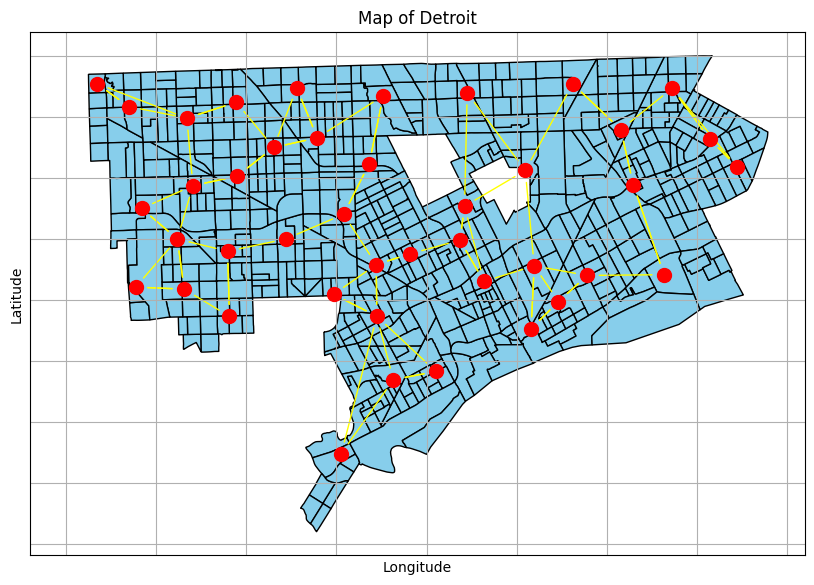

In [60]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# Calculates the distance between two points
def distance(coord1, coord2):
    """ 
    Calculates the eucledian distance between two points

    Parameters: 
    - coords1: first coordinate
    - coords2: second coordinate

    Returns: the distance

    """
    
    x1, y1 = coord1
    x2, y2 = coord2
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5


# Returns a dictionary of closest to farthest neighbors
def closest_neighbors(places_dict, target_point):

    """
    Gives a list of the closest neighbours from a reference point

    Parameters:
    - places_dict: Dictionary of locations and their coordinates
    - target_point: The location of reference

    Returns a list of places from closest to farthest from the reference point
    """

    # Initialize an empty dictionary 
    distances = {}
    
    for location, coord in places_dict.items():

        # Check that we are not comparing two of the same points
        if coord != target_point:
            
            # The location as a key and its distance as the value.
            distances[location] = distance(coord, target_point)

    # Sort distances from closest to farthest
    sorted_distances = sorted(distances.items(), key=lambda x: x[1])
    
    return sorted_distances

def nodes_edges_one_train(detroit_shapefile, places_dict):

    """
    Plots nodes and edges of the train system on a map

    Parameters:
    - detroit_shapefile: the file of the map
    - places_dict: dictionary of location and their coordinates

    Returns: A map with the nodes as locations and edges going from a point to its two nearest neighbors.

    """
    # Reads the shapefile
    detroit = gpd.read_file(detroit_shapefile)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the shapefile
    detroit.plot(ax=ax, color='skyblue', edgecolor='black')

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes at specified coordinates
    for place, coords in places_dict.items():
        # Add node to the graph
        G.add_node(place, pos=coords)

    # Call the distance function to get a list of distances 
    for place, coords in places_dict.items():
        
        dist = closest_neighbors(places_dict, coords)
        
        closest1 = dist[0][0] # Name of the closest neighbor
        closest2 = dist[1][0] # Name of the second closest neighbor

        # Add edges to the two closest neighbors
        G.add_edge(place, closest1) 
        G.add_edge(place, closest2)

    # Draw nodes 
    nx.draw_networkx_nodes(G, pos=places_dict, node_size=100, ax=ax, node_color='red')

    # Draw edges 
    nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')

    # Set title, labels, and grid
    plt.title('Map of Detroit')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # Display the plot
    plt.show()

# Example of places and their coordinates


# Path to shapefile
detroit_shapefile = 'datasets'

#Call the function
nodes_edges_one_train(detroit_shapefile, all_stops)

In [61]:
def nodes_edges(detroit_shapefile, places_dict):

    """
    Plots nodes and edges of the train system on a map

    Parameters:
    - detroit_shapefile: the file of the map
    - places_dict: dictionary of location and their coordinates in order of stops.

    Returns: A map with the nodes as locations and edges going from a point to the next stop as defined by the dictionary.

    """
    # Reads the shapefile
    detroit = gpd.read_file(detroit_shapefile)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the shapefile
    detroit.plot(ax=ax, color='skyblue', edgecolor='black')

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes at specified coordinates
    for place, coords in places_dict.items():
        # Add node to the graph
        G.add_node(place, pos=coords)

    # add edges from the previous stop to the next stop 
    for i in range(1, len(places_dict)):
        for j in range(1, 8): 
            current_stop = f"Route {i} Stop {j}"
            next_stop = f"Route {i} Stop {j + 1}"
            if next_stop not in places_dict:
                break  # Stop the loop if either the current or next stop is not in places_dict
            G.add_edge(current_stop, next_stop)
        
    # Draw nodes 
    nx.draw_networkx_nodes(G, pos=places_dict, node_size=100, ax=ax, node_color='red')

    
    #Draw edges
    nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')
    
    # Set title, labels, and grid
    plt.title('Map of Detroit')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)

    # Display the plot
    plt.show()

# Path to shapefile
detroit_shapefile = 'datasets'

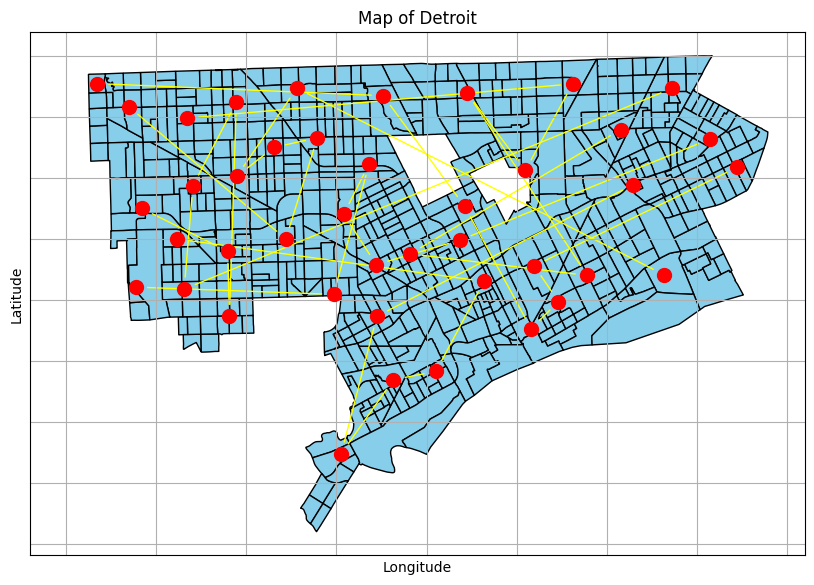

In [62]:
#Call the function
nodes_edges(detroit_shapefile, all_stops)

In [44]:
#Separating all routes into separate routes. 

# Initialize empty dictionary
routes = {}

# Iterate through the all_stops dictionary
for stop_name, coordinates in all_stops.items():
    
    # Extract the route number from the stop name
    route_num = stop_name.split()[1]  
    if route_num not in routes:
        routes[route_num] = {}
    routes[route_num][stop_name] = coordinates

def get_route(route_number):
    return routes.get(route_number, {})


route_1 = get_route('1')
route_2 = get_route('2')
route_3 = get_route('3')
route_4 = get_route('4')
route_5 = get_route('5')
route_6 = get_route('6')


/tmp/ipykernel_419274/1208089228.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


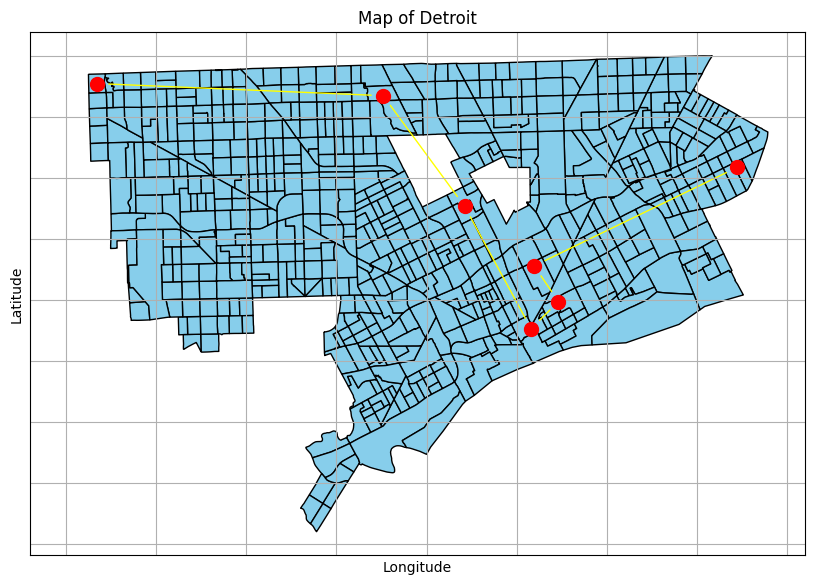

In [45]:
nodes_edges(detroit_shapefile, route_1)

/tmp/ipykernel_419274/1208089228.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


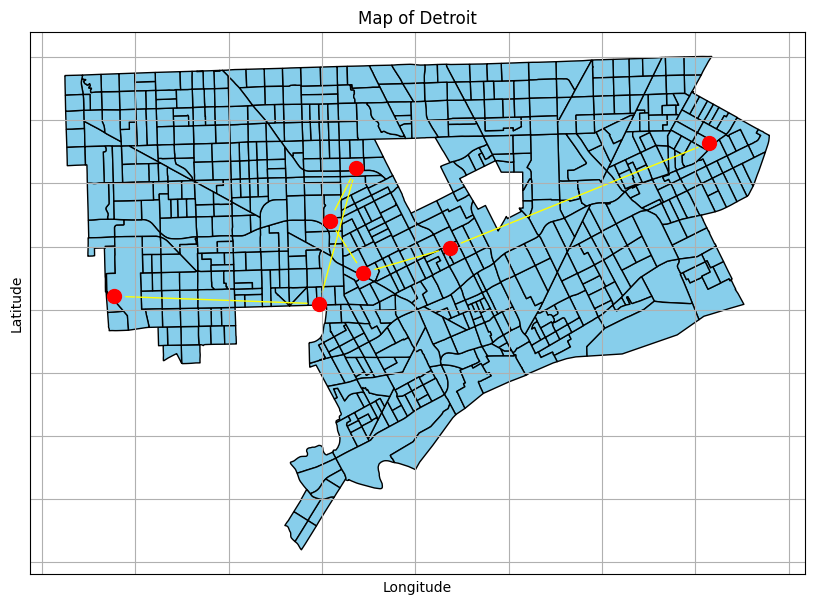

In [46]:
nodes_edges(detroit_shapefile, route_2)

/tmp/ipykernel_419274/1208089228.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


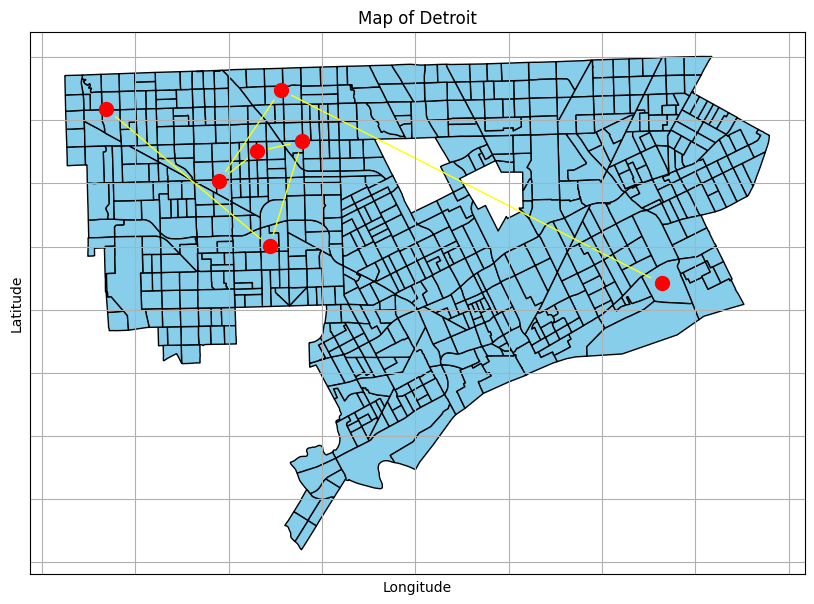

In [47]:
nodes_edges(detroit_shapefile, route_3)

/tmp/ipykernel_419274/1208089228.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


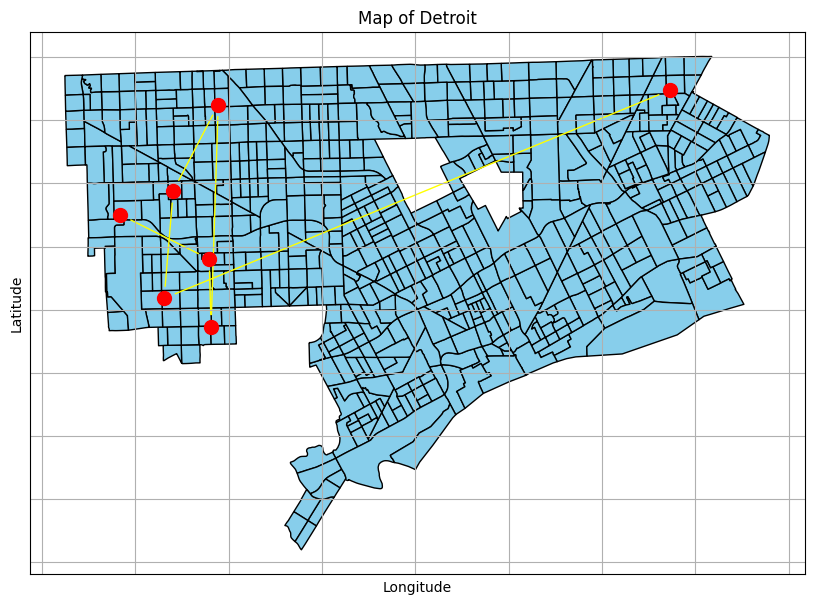

In [48]:
nodes_edges(detroit_shapefile, route_4)

/tmp/ipykernel_419274/1208089228.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


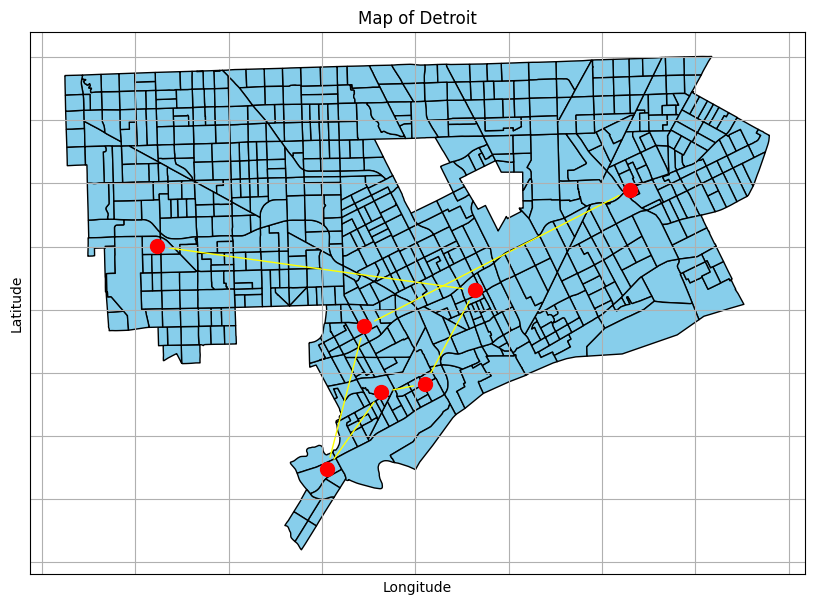

In [49]:
nodes_edges(detroit_shapefile, route_5)

/tmp/ipykernel_419274/1208089228.py:44: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos=places_dict, ax=ax, edge_color='yellow', arrowstyle='-')


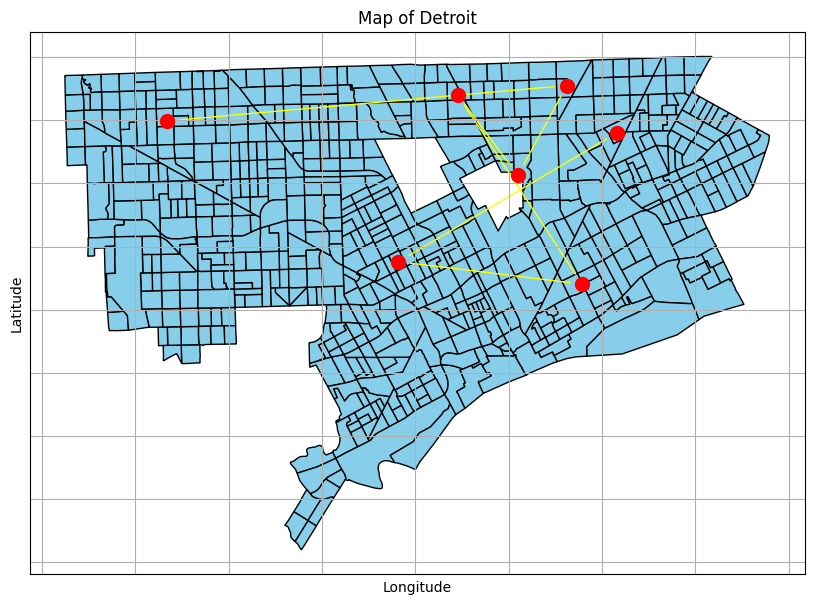

In [50]:
nodes_edges(detroit_shapefile, route_6)